<a href="https://colab.research.google.com/github/abdelhadidjafer02-beep/GPT-2/blob/main/LingMechInterp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**🔬 MechInterp Linguistics**

Research question (proxy-task grounded):

Where and how does GPT-2 encode grammatical number for subject–verb agreement, and can we causally control the verb choice?

This directly matches the paper’s principles:

* real behavior

* proxy task

* method minimalism

* causal intervention

In [ ]:
import torch
import numpy as np
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device=device
)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [ ]:
def next_token_probs(prompt, tokens=(" is", " are")):
    tokens_ids = [model.to_single_token(t) for t in tokens]
    logits = model(prompt)
    probs = torch.softmax(logits[0, -1], dim=-1)
    return {t: probs[i].item() for t, i in zip(tokens, tokens_ids)}


In [ ]:
prompts = [
    "The key to the cabinet",
    "The key to the cabinets",
    "The keys to the cabinet",
    "The keys to the cabinets",
]

for p in prompts:
    print(p, next_token_probs(p))


The key to the cabinet {' is': 0.04172096028923988, ' are': 0.0006603874498978257}
The key to the cabinets {' is': 0.21874332427978516, ' are': 0.03203316405415535}
The keys to the cabinet {' is': 0.021423719823360443, ' are': 0.2534698247909546}
The keys to the cabinets {' is': 0.013377002440392971, ' are': 0.26451846957206726}


In [ ]:
def run_with_cache(prompt):
    logits, cache = model.run_with_cache(prompt)
    return logits, cache


In [ ]:
singular_prompt = "The key to the cabinets"
plural_prompt   = "The keys to the cabinet"

_, cache_s = run_with_cache(singular_prompt)
_, cache_p = run_with_cache(plural_prompt)


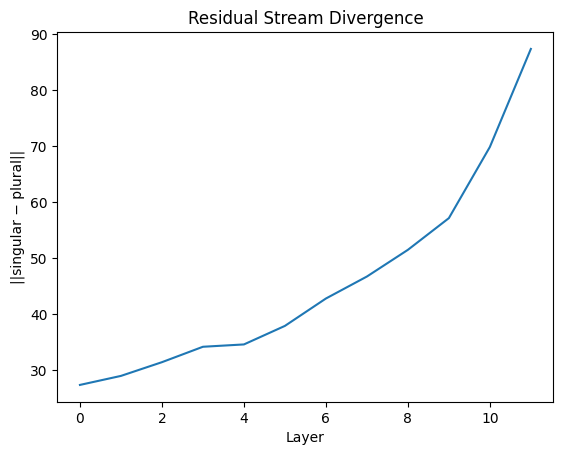

In [ ]:
layer_diffs = []

for layer in range(model.cfg.n_layers):
    res_s = cache_s["resid_post", layer][0, -1]
    res_p = cache_p["resid_post", layer][0, -1]
    diff = torch.norm(res_s - res_p).item()
    layer_diffs.append(diff)

plt.plot(layer_diffs)
plt.xlabel("Layer")
plt.ylabel("||singular − plural||")
plt.title("Residual Stream Divergence")
plt.show()


In [ ]:
def patch_resid(layer_to_patch):
    def hook(resid, hook):
        resid[:, -1, :] = cache_s["resid_post", layer_to_patch][:, -1, :]
        return resid
    return hook


In [ ]:
test_layer = int(np.argmax(layer_diffs))

patched_logits = model.run_with_hooks(
    plural_prompt,
    fwd_hooks=[(f"blocks.{test_layer}.hook_resid_post", patch_resid(test_layer))]
)

patched_probs = torch.softmax(patched_logits[0, -1], dim=-1)
print("Patched:", patched_probs[model.to_single_token(" is")].item(),
                   patched_probs[model.to_single_token(" are")].item())

print("Original:", next_token_probs(plural_prompt))


Patched: 0.21874332427978516 0.03203316405415535
Original: {' is': 0.021423719823360443, ' are': 0.2534698247909546}
